# 確率ロボティクス 2023 課題 &emsp;&emsp;20C1015 今井悠月<br>

## 取り組んだ内容：単純なグリッドワールドを用いて，Q学習により最適な方策の獲得を目指す<br>

### Q学習とは
#### ロボットが行動をとった後に得られる情報から, 行動価値関数を更新していくアルゴリズム
 
#### 具体的には，ロボットが状態 s から行動 a をし，状態 s’ になった直後の行動価値関数を以下のような式で更新する

\begin{equation}
   Q(s,a) \leftarrow (1-\alpha)Q(s,a) + \alpha[r + max_{a'}Q(s',a')]
 \end{equation}

### $\epsilon$_greedy方策

#### 確率的な方策を用いる

#### Q値が行動が意図しない行動をしたときに，価値が与えられ局所解に陥ることがある

#### これを防ぐために，確率$\epsilon$で行動をランダムにする

#### これにより，最適な方策が得られる可能性が上がる<br>

### 手順

 #### 1) Qtable，状態，行動，報酬などを初期化
 
 #### 2) $\epsilon$_greedy方策をもとに行動し，行動価値関数を更新  
 #### →　終了条件（指定のepisode）まで繰り返す<br>

### 参考にした本および昨年以前の提出者のコード


書籍「詳解 確率ロボティクス Pythonによる基礎アルゴリズムの実装」，著者：上田隆一 (KS理工学専門書) (日本語) 単行本（ソフトカバー）(2019/10/27)

YusukeKiyooka jupyter-notebook リポジトリ https://github.com/YusukeKiyooka/jupyter-notebook　
コードは流用していませんが，アイデアは参考しました<br>

## 実装

### 必要な関数のインポート

In [1]:
import numpy as np  # NumPyライブラリをインポート
import matplotlib.pyplot as plt  # Matplotlibライブラリをインポート
from IPython.display import clear_output  # Jupyter notebookの出力をクリアするための関数をインポート
from time import sleep  # sleep関数をインポート

### グリッドワールドおよび状態の定義

In [2]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size  # グリッドのサイズを設定
        self.state_space = [(i, j) for i in range(size) for j in range(size)]  # 状態空間を生成
        self.action_space = {'U': [-1, 0], 'D': [1, 0], 'L': [0, -1], 'R': [0, 1]}  # 行動空間を定義
        self.robot_position = [0, 0]  # ロボットの初期位置を設定

    def step(self, action):
        # 行動を適用してロボットの位置を更新
        self.robot_position = np.array(self.robot_position) + np.array(self.action_space[action])
        # ロボットの位置がグリッドの外に出ないように調整
        self.robot_position = np.clip(self.robot_position, 0, self.size-1)
        return list(self.robot_position)

    def render(self):
        # グリッドを描画
        grid = np.zeros((self.size, self.size))
        grid[tuple(self.robot_position)] = 1  # ロボットの位置を描画
        grid[self.size-1, self.size-1] = 0.5  # 目的地を描画
        clear_output(wait=True)
        plt.imshow(grid, cmap='viridis')
        plt.show()
        sleep(0.1)

### 各種パラメータ，状態遷移，方策などの定義

In [3]:
class QLearning:
    def __init__(self, env, alpha=0.5, gamma=0.9, epsilon=0.1, episodes=100):
        self.env = env  # 環境を設定
        self.alpha = alpha  # 学習率を設定
        self.gamma = gamma  # 割引率を設定
        self.epsilon = epsilon  # 探索率を設定
        self.episodes = episodes  # エピソード数を設定
        # Qテーブルを初期化（すべての状態と行動の組み合わせに対して0を設定）
        self.q_table = dict(((i, j), [0, 0, 0, 0]) for i, j in self.env.state_space)
        self.action_list = list(self.env.action_space.keys())  # 行動リストを作成
        self.history = []  # 各エピソードの結果を保存するためのリストを初期化

    def choose_action(self, state):
        # ε-greedy方策に基づいて行動を選択
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.action_list)  # ランダムに行動を選択
        else:
            action = self.action_list[np.argmax(self.q_table[state])]  # Q値が最大の行動を選択
        return action

    def learn(self):
        # Q学習のメインループ
        for episode in range(self.episodes):
            state = self.env.robot_position  # 現在の状態を取得
            steps = 0  # ステップ数を初期化
            while state != [self.env.size-1, self.env.size-1]:  # 目的地に到達するまでループ
                action = self.choose_action(tuple(state))  # 行動を選択
                next_state = self.env.step(action)  # 行動を適用して次の状態を取得
                reward = -1 if state != [self.env.size-1, self.env.size-1] else 0  # 報酬を設定
                old_value = self.q_table[tuple(state)][self.action_list.index(action)]  # 現在のQ値を取得
                next_max = np.max(self.q_table[tuple(next_state)])  # 次の状態での最大Q値を取得

                # Q値を更新
                new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
                self.q_table[tuple(state)][self.action_list.index(action)] = new_value

                state = next_state  # 状態を更新
                self.env.render()  # 環境を描画
                steps += 1  # ステップ数をインクリメント

            self.env.robot_position = [0, 0]  # ロボットの位置を初期化
            self.history.append(steps)  # ステップ数を履歴に保存

    def plot_learning_curve(self):  # 学習曲線をプロットするためのメソッドを追加
        plt.plot(self.history)
        plt.title('Learning curve')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.show()

### 実行

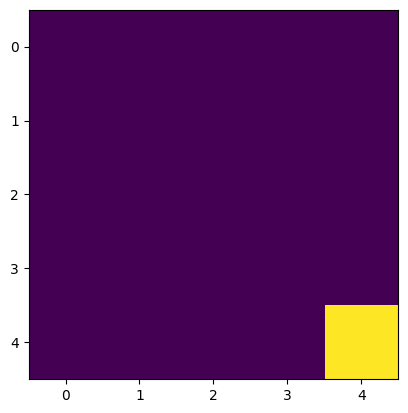

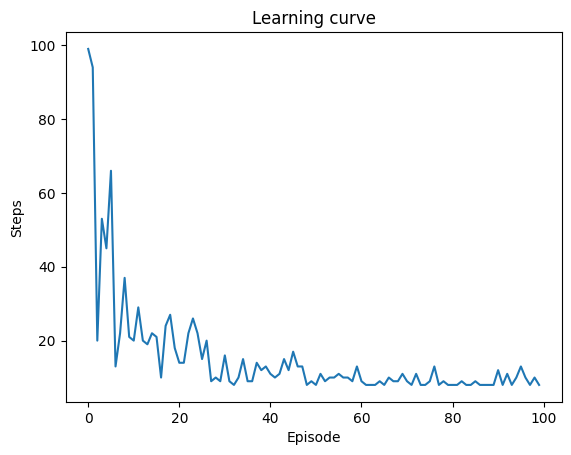

[99, 94, 20, 53, 45, 66, 13, 22, 37, 21, 20, 29, 20, 19, 22, 21, 10, 24, 27, 18, 14, 14, 22, 26, 22, 15, 20, 9, 10, 9, 16, 9, 8, 10, 15, 9, 9, 14, 12, 13, 11, 10, 11, 15, 12, 17, 13, 13, 8, 9, 8, 11, 9, 10, 10, 11, 10, 10, 9, 13, 9, 8, 8, 8, 9, 8, 10, 9, 9, 11, 9, 8, 11, 8, 8, 9, 13, 8, 9, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 8, 12, 8, 11, 8, 10, 13, 10, 8, 10, 8]


In [4]:
env = GridWorld()  # 環境を作成
agent = QLearning(env)  # エージェントを作成
agent.learn()  # 学習を開始
agent.plot_learning_curve()  # 学習曲線をプロット
print(agent.history)  # エージェントが各エピソードで必要としたステップ数を表示

### 実行時の様子（10 episode時）

### 動画のリンク　https://youtu.be/RNl6aDIfT48